PCLab#5 - Group 2 - Emanuele Sala, Luca Soleri, Fabio Stefana

<div style="border: 4px solid #007bff; padding: 10px; background-color: #e9f5ff; border-radius: 5px;">
    <h1 style="color: #007bff;">Importing libraries and Dataset</h1>
</div>


In [1]:
import pandas as pd
import os
import gc

In [2]:
directory = "data/sigwatch_data"
df_list = []

for file in os.listdir(directory):
    if file.endswith(".dta"):
        file_path = os.path.join(directory, file)
        temp_df = pd.read_stata(file_path)
        df_list.append(temp_df)
        
df = pd.concat(df_list, ignore_index=True)

<div style="border: 4px solid #007bff; padding: 10px; background-color: #e9f5ff; border-radius: 5px;">
    <h1 style="color: #007bff;">Day 1: Preliminary data exploration</h1>
</div>

In [66]:
# With this filter we keep only the banks
df = df[df["corp_industry_sector1"] == "Finance"]

In [ ]:
# And with this filter we only keep the countries form the US, UK or EU
countries = ['Austria',
             'US',
             'Denmark',
             'UK',
             'Germany',
             'Luxembourg',
             'France',
             'Italy',
             'Netherlands',
             'Belgium',
             'Sweden',
             'Spain',
             'Ireland',
             'Portugal',
             'Poland',
             'Finland',
             'USA',
             'Croatia',
             'Bulgaria',
             'Montenegro',
             'Bosnia and Herzegovina']

df = df[df['country_corp'].isin(countries)]
df.reset_index(drop=True, inplace=True)

In [68]:
# We count the unique number of ud_archive as some have more than one row but still count as one isngle campaing
n_of_campaigns = len(list(df["uid_archive"].unique()))
print(f"There are {n_of_campaigns} unique campaigns for US UK and EU banks")

There are 2370 unique campaigns for US UK and EU banks


In [69]:
list_of_ngo_columns = []
for i in range(5):
    i = i+1
    ngo_column_number = f"ngo_name{i}"
    ngo_col = list(df[ngo_column_number])
    list_of_ngo_columns += ngo_col
unique_ngos = list(set(list_of_ngo_columns))

# we do -1 because we have to account for the null value
print(f"There are {len(unique_ngos) - 1} unique NGO organizations involved in this dataset")

There are 932 unique NGO organizations involved in this dataset


In [112]:
# Get the number of unique firms targeted
num_firms_targeted = df['company'].nunique()

print(f"Number of firms targeted: {num_firms_targeted}")


Number of firms targeted: 815


In [118]:
unique_ngos_power = df['ngo_power1'].unique()

unique_prominence = df['prominence'].unique()

unique_sentiment = df['sentiment'].unique()

print(f"Unique NGO Power values: {unique_ngos_power}")
print(f"Unique Prominence values: {unique_prominence}")
print(f"Unique Sentiment values: {unique_sentiment}")

Unique NGO Power values: [2.5  0.5  1.   1.5  2.75 2.  ]
Unique Prominence values: [3 2 4 1 0]
Unique Sentiment values: [-2 -1  2  0  1]


The variables prominence, sentiment, and ngo_power likely represent different aspects of the firms and their interactions with NGOs or external factors.

prominence: This variable measures the visibility or importance of a firm in the context of the issue being discussed from 0, least visible, to 4, highest visible. A higher number may indicate greater prominence, such as higher media attention, public scrutiny, or relevance in the specific issue or campaign.

sentiment: This variable represents the sentiment associated with the firm or the coverage of the issue it is involved in. It is scored on a scale from -2 to +2, where negative values indicate negative sentiment, positive values indicate positive sentiment, and 0 or neutral values indicate no strong sentiment.


ngo_power (ngo_power1, ngo_power2, etc.): This variable measures the perceived influence of the NGO (Non-Governmental Organization) involved in the campaign or issue. A higher number indicates greater perceived power or influence of the NGO in shaping public opinion, affecting the firm, or pushing for changes. It goes from 0 to 3.


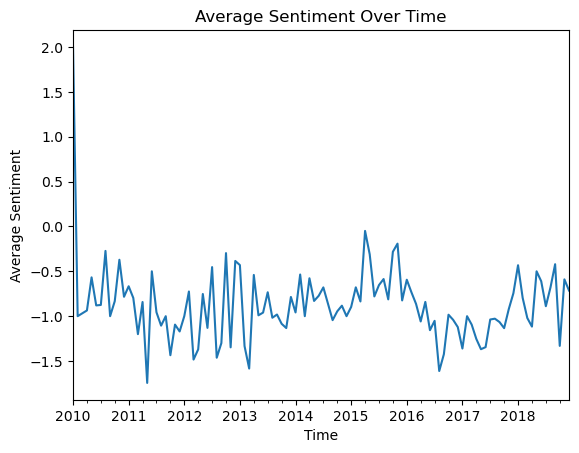

In [122]:
df['date'] = pd.to_datetime(df['date'])
sentiment_over_time = df.groupby(df['date'].dt.to_period('M'))['sentiment'].mean()
sentiment_over_time.plot()
plt.title('Average Sentiment Over Time')
plt.xlabel('Time')
plt.ylabel('Average Sentiment')
plt.show()


Over time, there is not a particular shift in terms of sentiment, which stay moderately negative from 2010 to 2019

In [ ]:
avg_sentiment_by_prominence = df.groupby('prominence')['sentiment'].mean()
print(avg_sentiment_by_prominence)

avg_sentiment_by_ngo_power = df.groupby('ngo_power1')['sentiment'].mean()
print(avg_sentiment_by_ngo_power)




prominence
0   -1.000000
1   -0.860390
2   -0.723370
3   -0.961952
4   -1.282843
Name: sentiment, dtype: float64
ngo_power1
0.50   -1.086207
1.00   -0.924983
1.50   -0.931360
2.00   -0.599237
2.50   -0.868298
2.75   -1.088889
Name: sentiment, dtype: float64


Prominence:
The prominence values are negative across the board, with scores ranging from -1.282843 to -0.723370.
These values suggest that the firms with higher prominence (less negative values) are still associated with overall negative sentiment. In this case, negative sentiment prevails across all levels of prominence, but firms with lower prominence seem to have slightly worse sentiment scores.


NGO Power (ngo_power1):
Similarly, the sentiment associated with different levels of NGO power is also predominantly negative. The sentiment scores range from -1.086207 to -0.599237.
As NGO power increases from 0.50 to 2.75, there is a slight variation in sentiment. The sentiment is least negative when ngo_power1 is at 2.00 (-0.599237), but generally, higher NGO power levels are still linked to negative sentiment, with some fluctuation around these values.



Prominent firms tend to receive negative sentiment, with no clear trend toward positive sentiment as prominence increases.
NGO power also does not seem to strongly shift sentiment in a positive direction. While there is slight variability in sentiment across different NGO power levels, the overall sentiment remains negative.
These results suggest that both prominence and NGO power are associated with negative sentiment, though the relationships are not drastically strong or linear. The sentiment might be influenced by other factors, and further exploration could help uncover more nuanced patterns.

<div style="border: 4px solid #007bff; padding: 10px; background-color: #e9f5ff; border-radius: 5px;">
    <h1 style="color: #007bff;">Task 2: Evaluating socual media attention through reddit</h1>
</div>

Unfortunately, we couldn't scrape the relevant data from Reddit due to API cost and the fact that the free tier did not allow for date filtering, hence the code would need to run for hours before reaching the relevant point in time, and still in that scenario we had no certainty about the success of the query. There were some methods before for filtering like using the Pushshift library, but it's not working anymore. The code still works if we want to scrape for example present data.

In [ ]:
import praw
import pandas as pd
from datetime import datetime, timedelta
import time


# Reddit API credentials
client_id = "RQswmwIqjV3DmpuBke34QQ"
client_secret = "EhyqqRfPu3x4EDVnsGTMD12y0xFbBQ"
user_agent = "finance_scrape (by u/Kashiko_02)"

# Set up the Reddit client
reddit = praw.Reddit(
    client_id=client_id,
    client_secret=client_secret,
    user_agent=user_agent
)

# Sample data from your dataset
df_1 = df.copy()
# Keep only the first few words of the report (to limit the query size)
df_1['report'] = df_1['report'].str[:100]

columns_to_keep = ['date', 'company', 'ngo_name1', 'ngo_name2', 'ngo_name3', 'ngo_name4', 'ngo_name5', 'report']
campaign = df_1.reindex(columns=columns_to_keep)
campaign = campaign.iloc[5000:5200]


# Data collection
reddit_data = []

for index, campaign in campaign.iterrows():
    if index % 50 == 0:
        time.sleep(2)

    

    ngos = [campaign['ngo_name1'], campaign['ngo_name2'], campaign['ngo_name3'], 
            campaign['ngo_name4'], campaign['ngo_name5']]
    
    campaign_date = datetime.strptime(campaign["date"], "%Y-%m-%d")
    campaign_year = campaign_date.year

    # Filter out empty NGO names and join them with spaces
    ngos = "; ".join([ngo for ngo in ngos if ngo])
    
    # Modify the search query to focus on the NGO names and the company
    search_query = f"{campaign['company']} {ngos}".strip()  
    
    search_limit = 20  # Adjust to your needs
    
    # Perform the search (focuses on the finance subreddit)
    submissions = reddit.subreddit("finance").search(search_query, limit=search_limit)
    
    # Convert campaign date to timestamp range
    date_before = campaign_date + timedelta(days=365)
    date_after = campaign_date - timedelta(days=100)

    # Filter and collect data
    for submission in submissions:
        # Convert Reddit post date
        post_date = datetime.utcfromtimestamp(submission.created_utc)
        post_date = datetime.strptime(str(post_date), "%Y-%m-%d %H:%M:%S")
        post_date = post_date.strftime("%Y-%m-%d")
        post_date = datetime.strptime(post_date, "%Y-%m-%d")
        
        # Check if post falls within the date range
        if date_after <= post_date <= date_before:
            # Check if the NGO names are mentioned in the post's title or text
            if any(ngo.lower() in submission.title.lower() or ngo.lower() in submission.selftext.lower() for ngo in ngos.split("; ") or 'ngo' in submission.title.lower() or 'ngo' in submission.selftext.lower()):
                reddit_data.append({
                    "company": campaign["company"],
                    "NGO": ngos,
                    "date": campaign["date"],
                    "title": submission.title,
                    "text": submission.selftext,
                    "created_utc": submission.created_utc,
                    "url": submission.url,
                })
                

# Save to a DataFrame
df_reddit = pd.DataFrame(reddit_data)

# Save to a CSV file
df_reddit.to_csv("reddit_data.csv", index=False)



<div style="border: 4px solid #007bff; padding: 10px; background-color: #e9f5ff; border-radius: 5px;">
    <h1 style="color: #007bff;">Task 3: Sentiment analysis from links</h1>
</div>

***Do not run it, it takes something like 300 minutes to completely run.***

This code scrapes text from URLs in a DataFrame, checks their accessibility, extracts content, and saves each row’s combined text in separate files. It starts by importing requests and BeautifulSoup for HTTP requests and HTML parsing, respectively. The is_url_accessible function verifies if a URL is reachable by checking its status code (200, 301, or 302). The get_text_from_url function follows redirects, skips non-HTML pages, and avoids error pages (e.g., with "404" in the title). It then extracts, cleans, and filters text based on a minimum length requirement. The code iterates through each row of the DataFrame, processing up to five URLs per row, and combines any extracted text. If valid text is found, it saves it to a uniquely named file for each row. This structure supports organized storage for further analysis but may face limitations with server rate limits, making it challenging for large datasets or historical data from certain sources.


In [109]:
import requests
from bs4 import BeautifulSoup

# Function to check if the URL is accessible
def is_url_accessible(url, timeout=3):
    try:
        response = requests.head(url, timeout=timeout, allow_redirects=True)  # Allow redirects
        # Check for successful status codes (200, 301, 302)
        return response.status_code in [200, 301, 302]
    except requests.RequestException as e:
        print(f"Error checking URL {url}: {e}")
        return False

# Function to fetch and parse content from the final destination URL after redirection
def get_text_from_url(url, timeout=5, min_length=2700):
    try:
        # First make the GET request with redirection allowed
        response = requests.get(url, timeout=timeout, allow_redirects=True)
        
        # Check if there is a redirect
        if response.status_code in [301, 302]:
            final_url = response.headers['Location']  # Get the final redirect URL
            response = requests.get(final_url, timeout=timeout)  # Fetch the redirected URL

        # Skip non-HTML content types
        if 'text/html' not in response.headers.get('Content-Type', ''):
            return None

        # Check if the title contains '404' or 'page is missing' to ignore these pages
        try:
            soup = BeautifulSoup(response.text, 'lxml')
            title = soup.title.string if soup.title else ""
            if "404" in title.lower() or "error" in title.lower() or "ops" in title.lower():
                return None  # Skip this page
        except Exception:
            soup = BeautifulSoup(response.text, 'html5lib')
            title = soup.title.string if soup.title else ""
            if "404" in title.lower() or "error" in title.lower() or "ops" in title.lower():
                return None  # Skip this page

        # Extract and clean up text
        unwanted_chars = [',', '\n', '\t', ';', '\\']
        extracted_text = ' '.join(
            ''.join(char for char in p.get_text() if char not in unwanted_chars)
            for p in soup.find_all('p')
        )
        
        # Only save text if it is longer than the minimum length specified
        if len(extracted_text) < min_length:
            return None
        
        return extracted_text

    except (requests.RequestException, Exception):
        return None
    
# Sample DataFrame for testing (just 20 row)
#df_filtered = df.head(20)

# Process and fetch text for links
text_data = []

total_rows = len(df)

for index, row in df.iterrows():
    print(f"Processing row {index + 1}/{total_rows}...")
    
    texts = []
    for col in ['link1', 'link2', 'link3', 'link4', 'link5']:
        url = row[col]
        if pd.notna(url):  # Check if there is a URL
            text = get_text_from_url(url)
            if text:
                texts.append(text)
    combined_text = ' '.join(texts)
    text_data.append(combined_text)

    # Optionally, save text for each row in a file or handle it as needed
    if combined_text:  # Only save if there's non-null text
        file_name = f"text_files/text_data_row_{index + 1}.txt"
        with open(file_name, "w") as file:
            file.write(combined_text)
        #print(f"Saved text for row {index + 1} to {file_name}")

print("All rows processed and saved into separate text files.")


Processing row 1/6625...


KeyboardInterrupt: 

This code detects and translates the content of text files, storing the translated text in a DataFrame. Using the langdetect library, it first checks the language of each text file, and if the content isn’t in English, it utilizes GoogleTranslator from deep_translator to translate the text to English. The detect_and_translate function handles large texts by splitting them into chunks of up to 4500 characters (to meet translation limits), translating each chunk individually, and then recombining them. For each file in a specified folder, the code extracts the row index from the filename, reads the text, detects its language, and translates it if necessary. Empty files are set to None. The processed content is then stored in the DataFrame’s text_from_links column at the appropriate row. This approach allows for efficient handling of moderately large text data, although high volumes may be limited by API rate or cost constraints.

Checking if it's in English, else we translate it

In [ ]:
from langdetect import detect
from deep_translator import GoogleTranslator

# Function to detect language and translate if necessary
def detect_and_translate(text):
    if not text:
        return None  # Handle cases with empty text
    
    try:
        # Detect language
        lang = detect(text)
        
        # If language is not English, proceed with translation
        if lang != 'en':
            # Check text length and split into smaller chunks if necessary
            max_chunk_length = 4500
            if len(text) > max_chunk_length:
                chunks = [text[i:i + max_chunk_length] for i in range(0, len(text), max_chunk_length)]
                translated_chunks = []
                
                # Translate each chunk
                for chunk in chunks:
                    translator = GoogleTranslator(source=lang, target='en')
                    translated_chunk = translator.translate(chunk)
                    translated_chunks.append(translated_chunk)
                
                # Combine translated chunks into a single string
                return ' '.join(translated_chunks)
            else:
                # If the text is within the limit, just translate it
                translator = GoogleTranslator(source=lang, target='en')
                translated_text = translator.translate(text)
                return translated_text
        else:
            return text  # Already in English, no translation needed

    except Exception as e:
        print(f"Error processing text: {e}")
        return text  # Return original text on detection failure
    
    
    


# Create a new column in the DataFrame for storing the text data
df['text_from_links'] = None

# Define the path to the folder containing the text files
folder_path = 'text_files'

# Iterate through each file in the folder
for filename in os.listdir(folder_path):
    if filename.startswith("text_data_row_") and filename.endswith(".txt"):
        # Extract the row index from the filename
        row_index = int(filename.split("_")[-1].split(".")[0]) - 1  # Adjust for 0-based index

        # Construct the full path to the file
        file_path = os.path.join(folder_path, filename)

        # Read the file content
        with open(file_path, 'r', encoding='utf-8') as file:
            text_content_raw = file.read().strip()  # Remove any leading/trailing whitespace
            #print(text_content_raw)

            # Only translate if there's actual content
            if text_content_raw:
                lang = detect(text)
                if lang != 'en':
                    text_content = detect_and_translate(text_content_raw)
                else:
                    text_content = text_content_raw
            else:
                text_content = None  # Handle empty file

        # Store the content in the corresponding row of the DataFrame
        df.at[row_index, 'text_from_links'] = text_content

print("Text content loaded into the DataFrame.")



text_data_row_3466.txt
text_data_row_4309.txt
text_data_row_5771.txt
text_data_row_3314.txt
text_data_row_3472.txt
text_data_row_1265.txt
text_data_row_6244.txt
text_data_row_5995.txt
text_data_row_3328.txt
text_data_row_6536.txt
text_data_row_2963.txt
text_data_row_6287.txt
text_data_row_295.txt
text_data_row_4484.txt
text_data_row_5942.txt
text_data_row_3664.txt
text_data_row_5215.txt
text_data_row_1067.txt
text_data_row_1701.txt
text_data_row_1729.txt
text_data_row_72.txt
text_data_row_4137.txt
text_data_row_3658.txt
text_data_row_4645.txt
text_data_row_99.txt
text_data_row_4692.txt
text_data_row_1098.txt
text_data_row_2591.txt
text_data_row_3857.txt
text_data_row_4686.txt
text_data_row_5598.txt
text_data_row_6091.txt
text_data_row_5407.txt
text_data_row_5361.txt
text_data_row_5375.txt
text_data_row_3704.txt
text_data_row_1675.txt
text_data_row_6132.txt
text_data_row_2432.txt
text_data_row_5349.txt
text_data_row_6126.txt
text_data_row_120.txt
text_data_row_1891.txt
text_data_row_473

This code performs sentiment analysis on text data from a DataFrame using the TextBlob library. The function analyze_sentiment first checks if the text is missing or empty; if so, it returns a default "neutral" sentiment with a polarity of 0. If the text exists, TextBlob calculates its polarity score, a value between -1 and 1 that indicates sentiment from negative to positive. Based on the polarity score, the code assigns a sentiment label ("positive," "neutral," or "negative") and rescales the polarity into discrete categories: 2 for strong positive (≥ 0.1), 1 for slight positive (≥ 0.01), -1 for slight negative (≤ -0.01), -2 for strong negative (≤ -0.1), and 0 for neutral.

The analyze_sentiments_with_progress function iterates through the DataFrame rows, applying analyze_sentiment to each row's text_from_links column and storing the results in lists. These lists, representing the sentiment labels and rescaled polarity scores, are then added to new columns in the original DataFrame. The tqdm library adds a progress bar to show processing progress. The final DataFrame includes columns for the sentiment labels and rescaled polarity scores derived from the text content in each row.

In [100]:
from textblob import TextBlob
from tqdm import tqdm  # For the progress bar


# Function to analyze sentiment using TextBlob
def analyze_sentiment(text):
    # Handle missing or null text
    if not text or pd.isnull(text):  # Check if text is None, NaN, or empty
        return 'neutral', 0  # Default neutral sentiment
    
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    
    if polarity >= 0.1:
        sentiment = 'positive'
        rescaled_polarity = 2
    elif polarity >= 0.01:
        sentiment = 'positive'
        rescaled_polarity = 1
    elif polarity <= -0.1:
        sentiment = 'negative'
        rescaled_polarity = -2
    elif polarity <= -0.01:
        sentiment = 'negative'
        rescaled_polarity = -1
    else:
        sentiment = 'neutral'
        rescaled_polarity = 0
    
    
    return sentiment, rescaled_polarity

# Apply sentiment analysis with progress tracking
def analyze_sentiments_with_progress(df):
    sentiments = []
    polarities = []
    
    # Add a progress bar using tqdm
    for idx, row in tqdm(df.iterrows(), total=df.shape[0], desc="Processing Rows"):
        text = row['text_from_links']
        sentiment, polarity = analyze_sentiment(text)
        sentiments.append(sentiment)
        polarities.append(polarity)
    
    # Add the results back to the DataFrame
    df['sentiment_from_links'] = sentiments
    df['polarity_from_links'] = polarities
    
    return df

# Call the function and see the results
df = analyze_sentiments_with_progress(df)

df

Processing Rows: 100%|██████████| 6625/6625 [00:20<00:00, 329.21it/s] 


,uid_archive,date,company_code,company,company_type,company_parent_code,company_parent,company_parent_country,sentiment,prominence,...,industry_sector4,report,link1,link2,link3,link4,link5,text_from_links,sentiment_from_links,polarity_from_links
0,40909,2011-12-21,3850,Bank Austria,Subsidiary,1149,UniCredit,Italy,-2,3,...,NaN,"In Austria, GLOBAL 2000 and Greenpeace activis...",http://www.global2000.at/site/de/nachrichten/a...,http://www.global2000.at/site/de/nachrichten/a...,,,NaN,None,neutral,0
1,40883,2011-12-21,49,World Bank,Parent,49,World Bank,US,-1,2,...,NaN,environmental impact assessment of the contro...,http://www.noticiasser.pe/16/12/2011/cajamarca...,https://www.rainforest-rescue.org/mailalert/80...,,,NaN,Our news reports and success stories in rainfo...,positive,1
2,40868,2011-12-19,3815,Jyske Invest International,Parent,3815,Jyske Invest International,Denmark,-1,4,...,NaN,"In Denmark, DanWatch claimed that Danish pensi...",http://www.danwatch.dk/da/artikler/danske-opsp...,,,,NaN,None,neutral,0
3,40868,2011-12-19,3816,Carnegie Asset Management,Parent,3816,Carnegie Asset Management,Denmark,-1,4,...,NaN,"In Denmark, DanWatch claimed that Danish pensi...",http://www.danwatch.dk/da/artikler/danske-opsp...,,,,NaN,None,neutral,0
4,40868,2011-12-19,3818,PenSam,Parent,3818,PenSam,Denmark,-1,4,...,NaN,"In Denmark, DanWatch claimed that Danish pensi...",http://www.danwatch.dk/da/artikler/danske-opsp...,,,,NaN,None,neutral,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6620,80469,2018-01-05,572,Danske Bank,Parent,572,Danske Bank,Denmark,-1,2,...,NaN,NORWAY - Norwegian CSR group Framtiden i Vare ...,https://www.framtiden.no/gronne-tips/fritid/bl...,,,,NaN,None,neutral,0
6621,80469,2018-01-05,2162,Nordea,Parent,2162,Nordea,Sweden,-1,2,...,NaN,NORWAY - Norwegian CSR group Framtiden i Vare ...,https://www.framtiden.no/gronne-tips/fritid/bl...,,,,NaN,None,neutral,0
6622,80469,2018-01-05,4427,Handelsbanken,Parent,4427,Handelsbanken,Sweden,1,2,...,NaN,NORWAY - Norwegian CSR group Framtiden i Vare ...,https://www.framtiden.no/gronne-tips/fritid/bl...,,,,NaN,None,neutral,0
6623,80453,2018-01-04,139,European Investment Bank EIB,Parent,139,European Investment Bank EIB,Luxembourg,-2,2,...,NaN,of national laws and international financial ...,https://bankwatch.org/press_release/european-f...,https://bankwatch.org/publication/broken-river...,,,NaN,Bankwatch 20 December 2017 The intake of the T...,positive,1


This code generates two visualizations to compare the sentiment of the original reports (from the sentiment column in the DataFrame) with the sentiment calculated from scraped text (in the polarity_from_links column). The first visualization, a Sentiment Distribution Comparison (KDE Plot), uses kernel density estimation (KDE) to show the distribution of sentiment scores for both sources, providing smoothed curves to indicate where the majority of sentiment scores fall. The second visualization, a Sentiment Range Comparison (Box Plot), displays the ranges and distributions of sentiment scores, using a reshaped DataFrame and box plot to show the median, interquartile range, and any outliers for each sentiment source. Together, these visualizations allow you to compare the overall distribution (KDE plot) and range (box plot) of the original and scraped sentiment scores, helping you assess similarities or differences in sentiment trends between the two sources.

/var/folders/d7/2bcv4v4544lcyzyb61mj51zm0000gn/T/ipykernel_923/187463720.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['sentiment'], shade=True, color='blue', label='Original Sentiment')
/var/folders/d7/2bcv4v4544lcyzyb61mj51zm0000gn/T/ipykernel_923/187463720.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['polarity_from_links'], shade=True, color='orange', label='Scraped Sentiment')


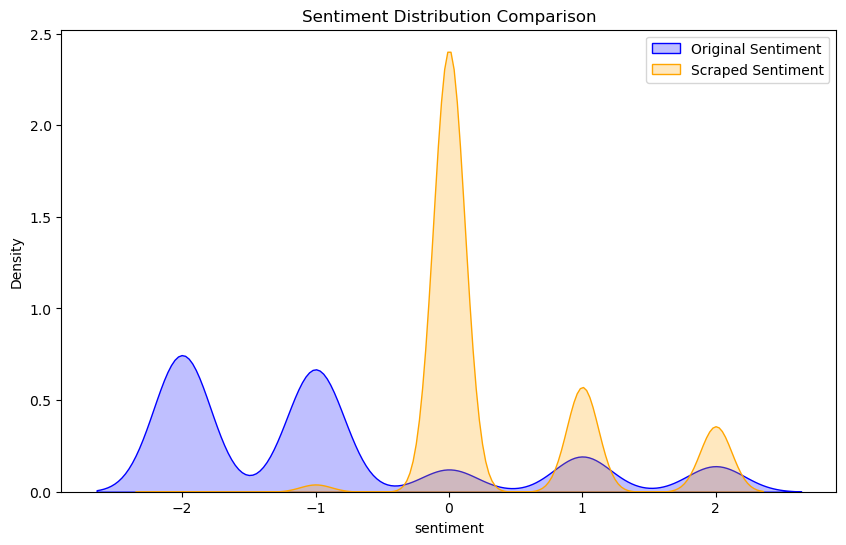

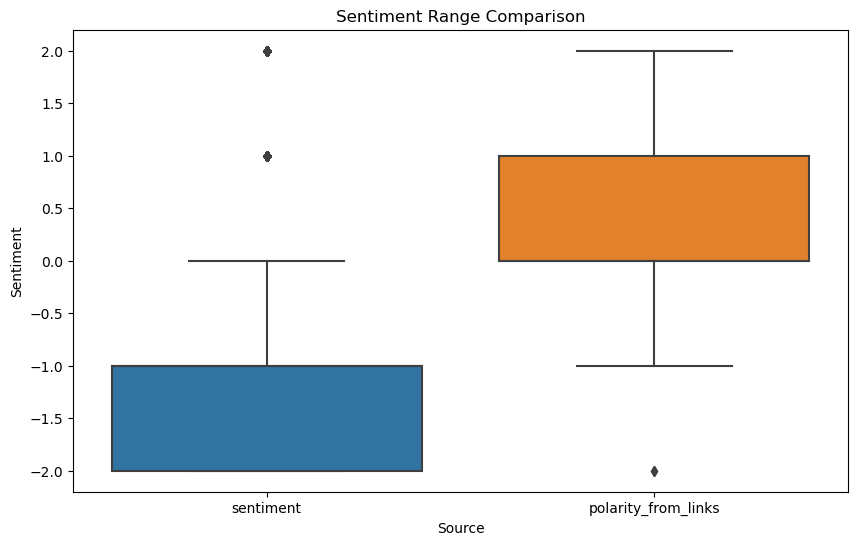

In [ ]:
##Compare the sentiment of the reports with the sentiment in the dataframe
import matplotlib.pyplot as plt
import seaborn as sns


# Distribution plot for both sentiment scores
plt.figure(figsize=(10, 6))
sns.kdeplot(df['sentiment'], shade=True, color='blue', label='Original Sentiment')
sns.kdeplot(df['polarity_from_links'], shade=True, color='orange', label='Scraped Sentiment')
plt.legend()
plt.title('Sentiment Distribution Comparison')
plt.show()

# Box plot to compare sentiment ranges
df_melted = df.melt(value_vars=['sentiment', 'polarity_from_links'], var_name='Source', value_name='Sentiment')
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_melted, x='Source', y='Sentiment')
plt.title('Sentiment Range Comparison')
plt.show()


The sentiment given in the dataset is really negative, while the polarity we obtained from the links is mostly neutral, and instead we see a prevalence of positive sentiment around the reports, which is kind of counterintuitive, and this could be because of the reasons stated in the paragraph below.

We can see how, in the end, it was not worth it to scrape the data from the link to perform the sentiment analysis, that is for several reasons:

1) We ended up missing on a lot of the data, maybe because links were not available anymore, or because they needed an ad-hoc scraper (think of having to accept cookies, being re-directed to another link, being re-directed to the landing page), which was something challenging to work around, and we didn't manage to fix all of the scenarios, so we ended up with 1992 items out of 6625

2) The model used for sentiment analysis was the best considering also the time needed, but given the fact that the majority of texts were really long, the best approach would have been to use  LLMs, dividing each text into right size chunks, feed them to the llm, and then averaging the score of that specific text. But this required a high-performing machine, and given also the volume of the data to analyze, it needed also a lot of time to run it, and in the end we understood it was not feasible. The model we used offers the best trade-off between quality and time, although for these kind of texts, it doesn't perform really well, in fact, before standardizing the polarity score, it was centered around 0, and the performance could have been similar to putting random values as sentiment, so the analysis in the end from the link is not satisfactory.

<div style="border: 4px solid #007bff; padding: 10px; background-color: #e9f5ff; border-radius: 5px;">
    <h1 style="color: #007bff;">Day 2: Exploring bank data</h1>
</div>

In [9]:
def read_banks(directory):
    # banks_ri.xlsm has the total return for each bank
    banks = pd.ExcelFile(directory)
    # Each workbook is divided into sheets that divide the banks into different countires
    # the first sheet is a request table so we will ignore it
    bank_sheets = banks.sheet_names[1:]
    first_df = banks.parse(bank_sheets[0])
    first_df = first_df.rename(columns={first_df.columns[0]: "Date"})
    other_dfs = [banks.parse(sheet_name).iloc[:, 1:] for sheet_name in bank_sheets[1:]]
    banks_df = pd.concat([first_df] + other_dfs, axis=1)
    return banks_df

def clean_banks_ri(banks_ri_df):
    # Rename columns so that they have cleaner names
    rename_dict = {"Date": "Date"}
    for col in banks_ri_df.columns[1:]:
        rename_dict[col] = col[:-17] + "_TR"
    banks_ri_df.rename(columns=rename_dict, inplace=True)
    # As we have 158 banks, we will drop all the banks that are marked as Dead, this is a simple 
    # solution around this problem and we are only doing this because we can afford to do so 
    # seeing how many banks we have. 
    # With this operation we will be dropping only 3 banks.
    dead_banks = []
    for col in banks_ri_df.columns[1:]:
        if "dead" in col.lower():
            dead_banks.append(col)
    banks_ri_df.drop(dead_banks, axis = 1, inplace = True)
    return banks_ri_df

banks_ri_df = read_banks("data/banks_data_bocconi/banks_ri.xlsm")
banks_ri_df = clean_banks_ri(banks_ri_df)
banks_ri_df.head(5)

,Date,AAREAL BANK_TR,COMDIRECT BANK_TR,COMMERZBANK_TR,DT.PFANDBRIEFBANK_TR,PROCREDIT HOLDING_TR,UMWELTBANK_TR,ALLIANZ_TR,DEUTSCHE BANK_TR,BANQUE NATIONALE DE BELGIQUE_TR,...,VIRGIN MONEY UK_TR,HSBC HOLDINGS_TR,LLOYDS BANKING GROUP_TR,METRO BANK_TR,ROYAL BANK OF SCTL.GP._TR,STANDARD CHARTERED_TR,TBC BANK GROUP_TR,ADMIRAL GROUP_TR,ALLIANCE TRUST_TR,SAGA GROUP_TR
0,2008-01-01,182.27,33.09,974.59,NaN,NaN,260.15,3364.43,1937.46,2658.11,...,NaN,1502.17,271.20,NaN,82190.06,79476.00,NaN,449.44,14717.18,1438.33
1,2008-01-02,183.81,33.05,956.43,NaN,NaN,259.22,3304.22,1900.87,2684.50,...,NaN,1489.68,269.47,NaN,81079.38,79001.88,NaN,447.39,14764.00,1438.33
2,2008-01-03,181.73,33.05,944.94,NaN,NaN,261.69,3285.59,1900.00,2682.82,...,NaN,1495.93,270.91,NaN,81912.38,78657.13,NaN,449.44,14866.32,1438.33
3,2008-01-04,173.31,33.09,939.75,NaN,NaN,263.24,3220.61,1881.60,2641.91,...,NaN,1476.30,261.43,NaN,78348.94,77665.81,NaN,436.36,14538.91,1438.33
4,2008-01-07,167.91,33.20,943.08,NaN,NaN,259.37,3179.94,1880.52,2632.54,...,NaN,1486.11,259.71,NaN,77423.38,77924.38,NaN,431.87,14549.14,1438.33


The banks_ri dataset provides the Total Return Index, this includes both price changes and the effect of dividends reinvested back into the stock. If the bank pays dividends, these dividends are considered to be reinvested, adding to the growth of the index. 

This index provides a more comprehensive view of the stock’s overall return by including income from dividends, making it useful for capturing the full picture of what an investor earns from holding the stock.

In [10]:
def clean_banks_pi(banks_pi_df):
    rename_dict = {"Date": "Date"}
    for col in banks_pi_df.columns[1:]:
        rename_dict[col] = col[:-14] + "_PI"
    banks_pi_df.rename(columns=rename_dict, inplace=True)
    dead_banks = []
    for col in banks_pi_df.columns[1:]:
        if "dead" in col.lower():
            dead_banks.append(col)
    banks_pi_df.drop(dead_banks, axis = 1, inplace = True)
    return banks_pi_df

banks_pi_df = read_banks("data/banks_data_bocconi/banks_pi.xlsm")
banks_pi_df = clean_banks_pi(banks_pi_df)
banks_pi_df.head(5)

,Date,AAREAL BANK_PI,COMDIRECT BANK_PI,COMMERZBANK_PI,DT.PFANDBRIEFBANK_PI,PROCREDIT HOLDING_PI,UMWELTBANK_PI,ALLIANZ_PI,DEUTSCHE BANK_PI,BANQUE NATIONALE DE BELGIQUE_PI,...,CLOSE BROTHERS GROUP_PI,VIRGIN MONEY UK_PI,HSBC HOLDINGS_PI,LLOYDS BANKING GROUP_PI,METRO BANK_PI,ROYAL BANK OF SCTL.GP._PI,STANDARD CHARTERED_PI,ADMIRAL GROUP_PI,ALLIANCE TRUST_PI,SAGA GROUP_PI
0,2008-01-01,171.1,27.2,353.5,NaN,NaN,224.0,2132.9,802.2,714.9,...,8202.5,NaN,784.5,137.4,NaN,11418.8,8372.5,400.0,3044.2,854.3
1,2008-01-02,172.6,27.1,346.9,NaN,NaN,223.2,2094.8,787.1,722.0,...,8198.2,NaN,778.0,136.5,NaN,11264.5,8322.5,398.2,3037.9,854.3
2,2008-01-03,170.6,27.1,342.7,NaN,NaN,225.3,2082.9,786.7,721.5,...,8202.5,NaN,781.2,137.3,NaN,11380.3,8286.2,400.0,3059.0,854.3
3,2008-01-04,162.7,27.2,340.8,NaN,NaN,226.7,2041.8,779.1,710.5,...,8332.0,NaN,771.0,132.5,NaN,10885.2,8181.8,388.4,2991.6,854.3
4,2008-01-07,157.7,27.3,342.1,NaN,NaN,223.3,2016.0,778.7,708.0,...,8336.3,NaN,776.1,131.6,NaN,10756.6,8209.0,384.4,2993.7,854.3


NOTE: The banks_pi dataset contains 3 more banks than the banks_pi dataset, those banks are all 3 located in Austria and they are:
- ERSTE GROUP BANK
- RAIFFEISEN BANK INTL
- VOLKSBANK VBG.PARTN.

On the other hand, the banks_pi dataset contains the Price Index, which only reflects a stock’s price movements without accounting for dividends or other distributions. It provides a pure measure of price appreciation, capturing changes in the stock's market price alone. 

This makes it more suitable for CAPM estimation, as we are focused on price shifts rather than the total return an investor would earn if they held the stock and reinvested dividends.

<strong>To clarify, we'll now rely exclusively on the banks_pi dataset to carry out our analysis.</strong>

<div style="border: 4px solid #007bff; padding: 10px">
    <h3 style="color: #007bff;">Now we load the Fama-French info</h1>
</div>

In [11]:
# First we get the start and end date of our bank data
start = banks_pi_df["Date"].iloc[0]
end = banks_pi_df["Date"].iloc[-1]

# And now we can read in the Factors and keep only the days we need
EU_FF = pd.read_excel("data/banks_data_bocconi/Europe_3_Factors_Daily.xlsx")
EU_FF['date'] = pd.to_datetime(EU_FF['date'], format="%m/%d/%Y")
EU_FF = EU_FF[(EU_FF["date"] >= start) & (EU_FF["date"] <= end)]
rename_dict_EU = {"date": "date"}
for col in EU_FF.columns[1:]:
    rename_dict_EU[col] = col + "_EU"
EU_FF.rename(columns=rename_dict_EU, inplace=True)

US_FF = pd.read_excel("data/banks_data_bocconi/North_America_3_Factors_Daily.xlsx")
US_FF['date'] = pd.to_datetime(US_FF['date'], format="%m/%d/%Y")
US_FF = US_FF[(US_FF["date"] >= start) & (US_FF["date"] <= end)]
US_FF.drop("date", axis = 1, inplace = True)
rename_dict_US = {}
for col in US_FF.columns:
    rename_dict_US[col] = col + "_US"
US_FF.rename(columns=rename_dict_US, inplace=True)

FF = pd.concat([EU_FF, US_FF], axis = 1)
FF.reset_index(drop = True, inplace = True)

# Now we calculate the market return, as we have (rm -rf) and rf its quite simple
FF["MKT_EU"] = FF["Mkt-RF_EU"] - FF["RF_EU"]
FF["MKT_US"] = FF["Mkt-RF_US"] - FF["RF_US"]

FF.head(5)

,date,Mkt-RF_EU,SMB_EU,HML_EU,RF_EU,Mkt-RF_US,SMB_US,HML_US,RF_US,MKT_EU,MKT_US
0,2008-01-01,0.02,0.00,0.00,0.01,0.04,0.05,0.01,0.01,0.01,0.03
1,2008-01-02,-0.11,0.94,0.23,0.01,-1.25,0.09,-0.22,0.01,-0.12,-1.26
2,2008-01-03,-0.13,-0.22,0.11,0.01,-0.03,-0.66,-0.42,0.01,-0.14,-0.04
3,2008-01-04,-1.74,0.39,0.30,0.01,-2.59,-0.45,0.29,0.01,-1.75,-2.60
4,2008-01-07,-0.79,-1.03,0.16,0.01,0.02,-0.22,0.24,0.01,-0.80,0.01


<div style="border: 4px solid #007bff; padding: 10px">
    <h3 style="color: #007bff;">Now we calculate the daily returns for each bank</h1>
</div>

In [12]:
def calculate_return(stock, returns_df):
    shifted = returns_df[stock].shift(1)
    return_series = (returns_df[stock] - shifted) / shifted
    return return_series.rename(f"{stock}_r")

returns_dict = {}

tickers = banks_pi_df.columns[1:]
for stock in tickers:
    returns_dict[f"{stock}_r"] = calculate_return(stock, banks_pi_df)

returns_df = pd.concat(returns_dict.values(), axis=1)

<div style="border: 4px solid #007bff; padding: 10px">
    <h3 style="color: #007bff;">Now we put everything togheter into a single panel</h1>
</div>

In [13]:
bank_data = pd.concat([banks_pi_df, returns_df, FF], axis=1)

<div style="border: 4px solid #007bff; padding: 10px; background-color: #e9f5ff; border-radius: 5px;">
    <h1 style="color: #007bff;">Task 4: Estimating the CAPM </h1>
</div>

<div style="border: 4px solid #007bff; padding: 10px">
    <h3 style="color: #007bff;">Preparing the data</h1>
</div>

We need to create a list of the banks located in the us so that we can differentiate the different us and eu market returns and risk frees

In [14]:
# We need to create a list of the banks located in the us so that we can differentiate the different us and eu market returns and risk frees 
us_banks = []
banks_pi = pd.ExcelFile("data/banks_data_bocconi/banks_ri.xlsm")
us_banks_raw = list(banks_pi.parse("US").columns)[1:]
for bank in us_banks_raw:
    us_banks.append(bank[:-17] + "_PI_r")
us_banks = [bank for bank in us_banks if "DEAD" not in bank]
# Delete banks_pi and us_banks_raw to free memory
del banks_pi, us_banks_raw
gc.collect()

3847

In [15]:
# We create a new dataframe that better fits this task and that includes all the necessary data
task4_cols = ["Date", "Mkt-RF_US", "Mkt-RF_EU"]

for col in bank_data.columns:
    if col.endswith("_r"):
        task4_cols.append(col)

task4_data = bank_data[task4_cols].copy()

<div style="border: 4px solid #007bff; padding: 10px">
    <h3 style="color: #007bff;">Estimating the CAPM</h1>
</div>

Now we will estimate the CAPM on a rolling window, choosing a window size of 130 days. We decided to use 130 days as this roughly corresponds to 6 months of trading days, which is a sufficient time period to capture medium-term market dynamics while still being responsive to recent changes.

In [16]:
import statsmodels.api as sm

def get_mkt_data(bank_data, bank, us_banks):
    if bank in us_banks:
        mkt_data = bank_data["Mkt-RF_US"].copy()
    else:
        mkt_data = bank_data["Mkt-RF_EU"].copy()
    return mkt_data

def rollin_window_CAPM(bank_data, bank, us_banks, window_size = 130):
    current_bank = bank_data[["Date", f"{bank}"]].copy()
    mkt_data = get_mkt_data(bank_data, bank, us_banks)
    current_bank["MKT"] = mkt_data

    P_values = pd.DataFrame()
    alphas = []
    betas = []
    
    for i in range(len(current_bank) - window_size + 1):
        window = current_bank.iloc[i:i + window_size] 

        X = sm.add_constant(window["MKT"])  
        y = window[bank] 
        model = sm.OLS(y, X).fit()  
    
        # Extract parameter of intrest
        alpha = model.params.iloc[0]
        beta = model.params.iloc[1]
        p_value_alpha = model.pvalues.iloc[0]
        p_value_beta = model.pvalues.iloc[1]
    
        # Create a dictionary to store the results for the current stock
        result_i = {"Alpha": alpha,
                    "Beta": beta,
                    "P Value Alpha": p_value_alpha,
                    "P Value Beta": p_value_beta}
        betas.append(beta)
        alphas.append(alpha)
         
        result_df = pd.DataFrame(result_i, index=[i])  
        P_values = pd.concat([P_values, result_df]) 
    P_values.reset_index(inplace = True)
    P_values.rename(columns={'index': 'Stock'}, inplace = True)
    return P_values, betas, alphas
    

In [17]:
%%time
from tqdm import tqdm # This creates a nice progress bar

CAPM_results = {}
betas_dic = {}
alphas_dic = {}
for bank_i in tqdm(task4_data.columns[3:]):
    P_values, betas_i, alpha_i = rollin_window_CAPM(task4_data, bank_i, us_banks)
    CAPM_results[bank_i] = P_values
    betas_dic[bank_i] = betas_i
    alphas_dic[bank_i] = alpha_i
    
alphas_df = pd.DataFrame(alphas_dic)
betas_df = pd.DataFrame(betas_dic)

100%|██████████| 157/157 [04:40<00:00,  1.79s/it]

CPU times: user 4min 39s, sys: 1.24 s, total: 4min 41s
Wall time: 4min 40s


<div style="border: 4px solid #007bff; padding: 10px">
    <h3 style="color: #007bff;">Viewing the results</h1>
</div>

In [18]:
betas_df.reset_index(inplace = True, drop = True)
alphas_df.reset_index(inplace = True, drop = True)
betas_df["mean"] = betas_df.mean(axis=1, skipna=True)
alphas_df["mean"] = alphas_df.mean(axis=1, skipna=True)

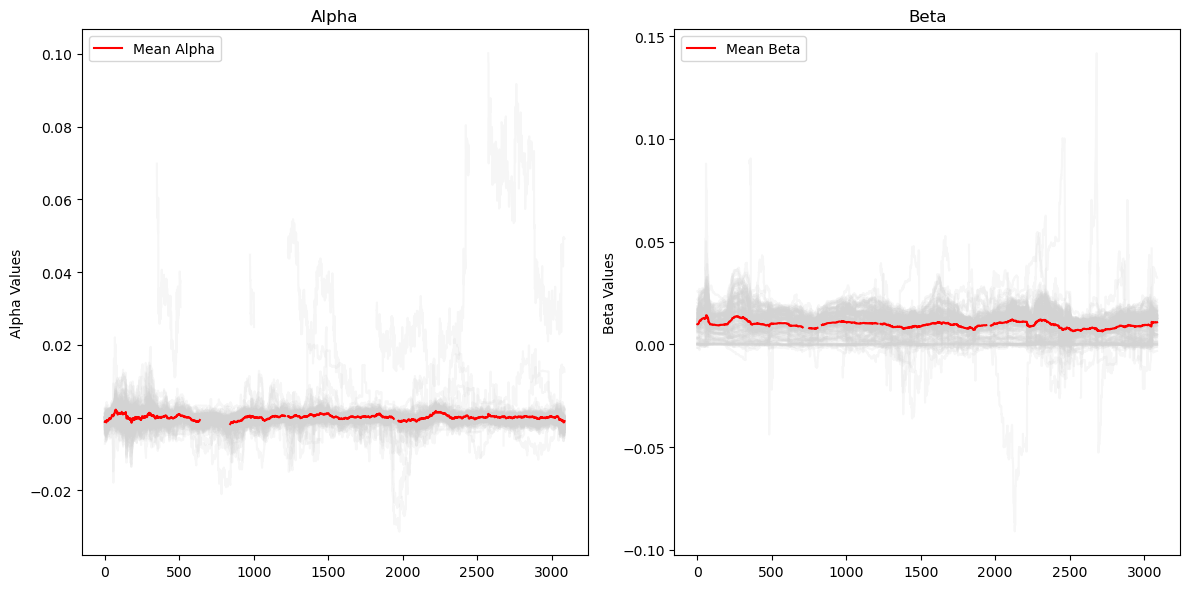

In [19]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

for col in alphas_df.columns:
    axs[0].plot(alphas_df.index, alphas_df[col], color="lightgray", alpha=0.2)
axs[0].plot(alphas_df.index, alphas_df["mean"], color="red", label="Mean Alpha")

for col in betas_df.columns:
    axs[1].plot(betas_df.index, betas_df[col], color="lightgray", alpha=0.2)
axs[1].plot(betas_df.index, betas_df["mean"], color="red", label="Mean Beta")

# Set titles and labels
axs[1].set_title("Beta")
axs[1].set_ylabel("Beta Values")
axs[0].set_title("Alpha")
axs[0].set_ylabel("Alpha Values")

# Add legends
axs[0].legend()
axs[1].legend()

plt.tight_layout()  # Adjust spacing to prevent overlap
plt.show()

At a first glance, our results provide significant insights into the estimated alpha (α) and beta (β) values. As anticipated, the average alpha remains close to zero, aligning with the theoretical implications of the CAPM model, which suggests that, on average, no excess returns are expected after adjusting for systematic risk. However, a closer inspection of individual bank data—represented by the faded gray lines—reveals substantial variation in alpha values across different banks. This variability suggests that while CAPM holds reasonably well at an aggregate level, individual bank dynamics often deviate from the model due to unique real-world factors. These deviations result in non-zero alpha values for many banks, indicating potential influences such as market-specific shocks, regulatory differences, or other idiosyncratic factors that may not be fully captured by CAPM. Thus, while CAPM may describe general trends, it may be less reliable for forecasting performance at a granular, bank-specific level.

In the second graph, we focus on the beta (β) estimates, which provide insight into the sensitivity of each bank's returns to market movements. Similar to our observations with alpha, we see considerable variability in the beta values across the sample. Most of the beta estimates fall within the 0 to 0.05 range, which appears reasonable given the nature of the banking sector.
This relatively low beta range suggests that, on average, banks exhibit lower sensitivity to overall market fluctuations compared to other equities. The conservative investment strategies, regulatory oversight, and stable business models typical of banks often result in lower systematic risk, thus explaining the modest beta values.

In [20]:
betas_df["us_banks"] = betas_df[us_banks].mean(axis=1)
betas_df["eu_uk_banks"] = betas_df[betas_df.columns.difference(us_banks)].mean(axis=1)
alphas_df["us_banks"] = alphas_df[us_banks].mean(axis=1)
alphas_df["eu_uk_banks"] = alphas_df[alphas_df.columns.difference(us_banks)].mean(axis=1)

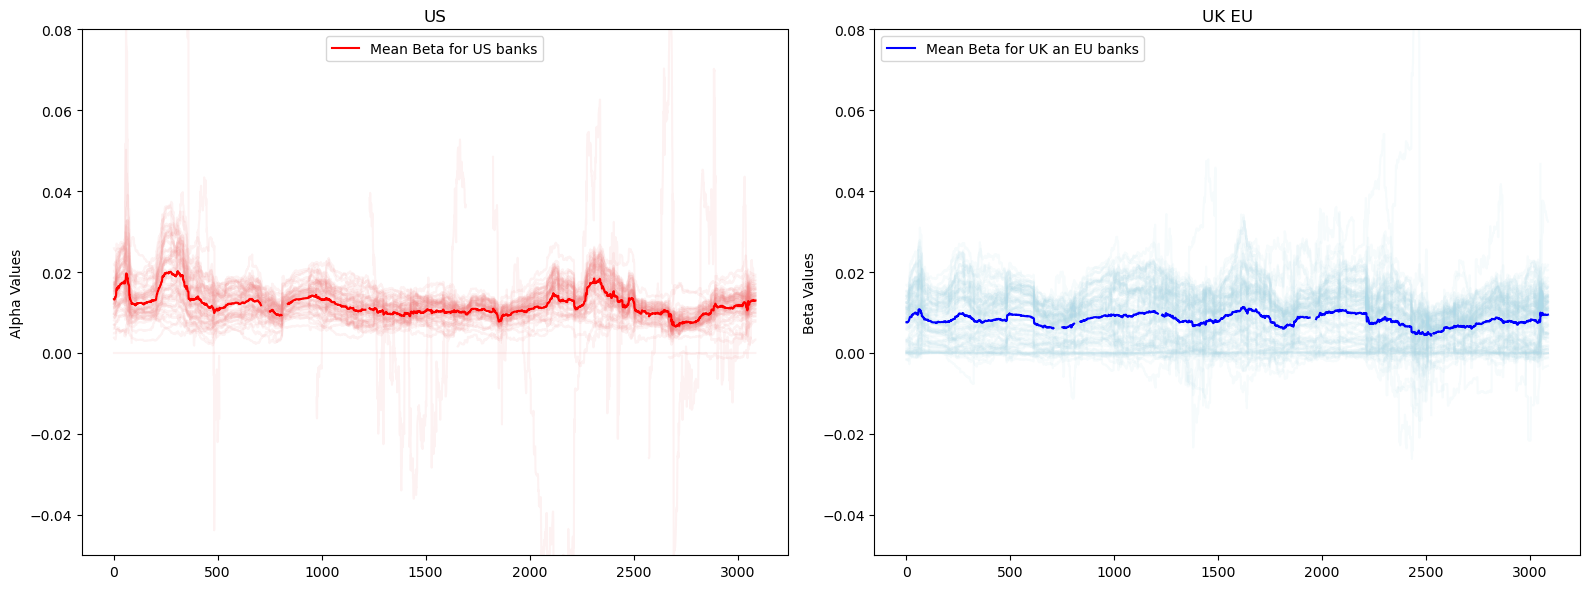

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

for col in betas_df.columns:
    if col in us_banks:
        axs[0].plot(betas_df.index, betas_df[col], color="lightcoral", alpha=0.1)
axs[0].plot(betas_df.index, betas_df["us_banks"], color="red", label="Mean Beta for US banks")

for col in betas_df.columns:
    if col not in us_banks:
        axs[1].plot(betas_df.index, betas_df[col], color="lightblue", alpha=0.1)
axs[1].plot(betas_df.index, betas_df["eu_uk_banks"], color="blue", label="Mean Beta for UK an EU banks")



# Set titles and labels
axs[1].set_title("UK EU")
axs[1].set_ylabel("Beta Values")
axs[0].set_title("US")
axs[0].set_ylabel("Alpha Values")
# Set y-axis limits
axs[0].set_ylim(-0.05, 0.08)
axs[1].set_ylim(-0.05, 0.08)


# Add legends
axs[0].legend()
axs[1].legend()
plt.tight_layout()  # Adjust spacing to prevent overlap
plt.show()

When we examine the US and European markets separately, distinct differences in the distribution of beta estimates become evident. In the US market, we observe significantly higher variance, with a noticeable presence of both positive and negative outliers. This indicates that individual banks in the US exhibit a wider range of sensitivities to market movements, suggesting a more heterogeneous risk profile across the sector.

In contrast, the European market shows a much tighter clustering of beta values around its mean, indicating lower variability among banks. This tighter distribution suggests that European banks, on average, have more uniform exposure to market risk. Several factors could contribute to this difference: the European banking sector may have more stringent regulatory frameworks, a higher degree of risk-averse strategies, or more homogeneous business models focused on traditional banking activities.

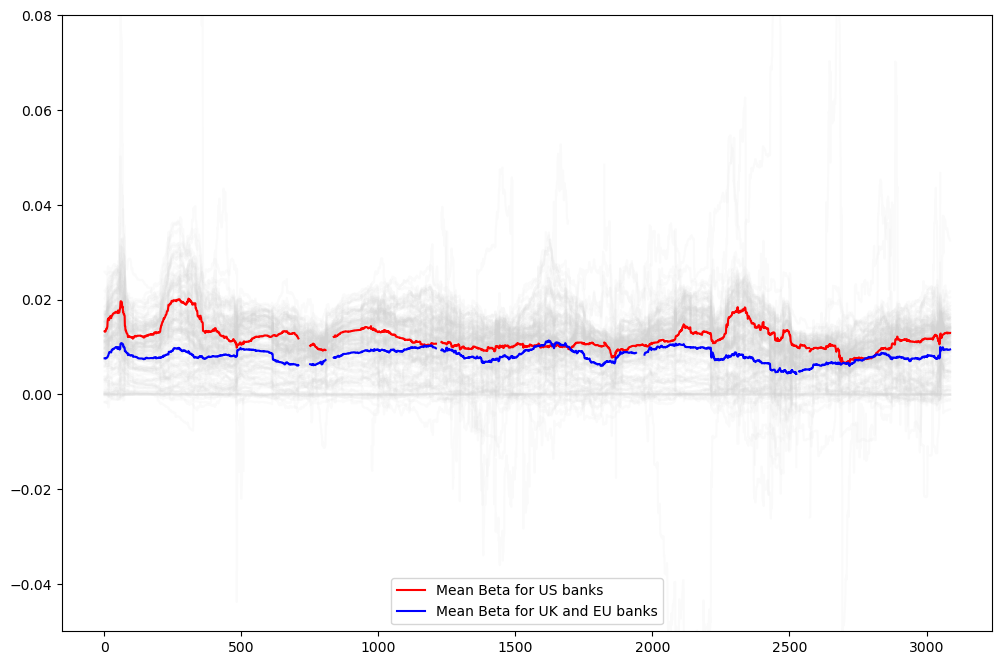

In [45]:
plt.figure(figsize=(12, 8))

for col in betas_df.columns:
    plt.plot(betas_df.index, betas_df[col], color="lightgray", alpha=0.1)
plt.plot(betas_df.index, betas_df["us_banks"], color="red", label="Mean Beta for US banks")
plt.plot(betas_df.index, betas_df["eu_uk_banks"], color="blue", label="Mean Beta for UK and EU banks")

plt.ylim(-0.05, 0.08)
plt.legend()
plt.show()

This plot provides valuable insights by directly comparing the mean beta estimates between the US and European banking markets. As anticipated, the average beta in the US market is significantly higher than that of its European counterpart. This outcome aligns with expectations, given the characteristics of the US financial market.

The higher mean beta in the US suggests that American banks, on average, exhibit greater sensitivity to market movements compared to European banks. This can be attributed to several factors. Firstly, the US is the largest and most dynamic equity market globally, often acting as a bellwether for economic performance. The greater size and liquidity of the US market can lead to higher exposure to systemic risk, driving up beta estimates for US banks.
Another crucial factor contributing to the difference in beta estimates between US and European banks is the distinct nature of their core activities. In the European Union, banks are the predominant lenders in the financial system, with a strong emphasis on traditional lending activities. European banks primarily focus on extending credit to businesses and consumers, making lending a significant component of their business model. As a result, their profitability is closely tied to interest income from loans, which tends to be more stable and less influenced by short-term market fluctuations.

In contrast, as discussed in class, US banks have a markedly lower share of consumer loans relative to the total lending in the economy. Instead of relying primarily on lending activities, many US banks employ their deposits in potentially more profitable ways, such as investing in the bond or stock markets. This diversification of asset allocation, with a greater emphasis on capital market investments, increases their exposure to broader market volatility. Consequently, US banks are more sensitive to changes in market conditions, leading to higher average beta values.

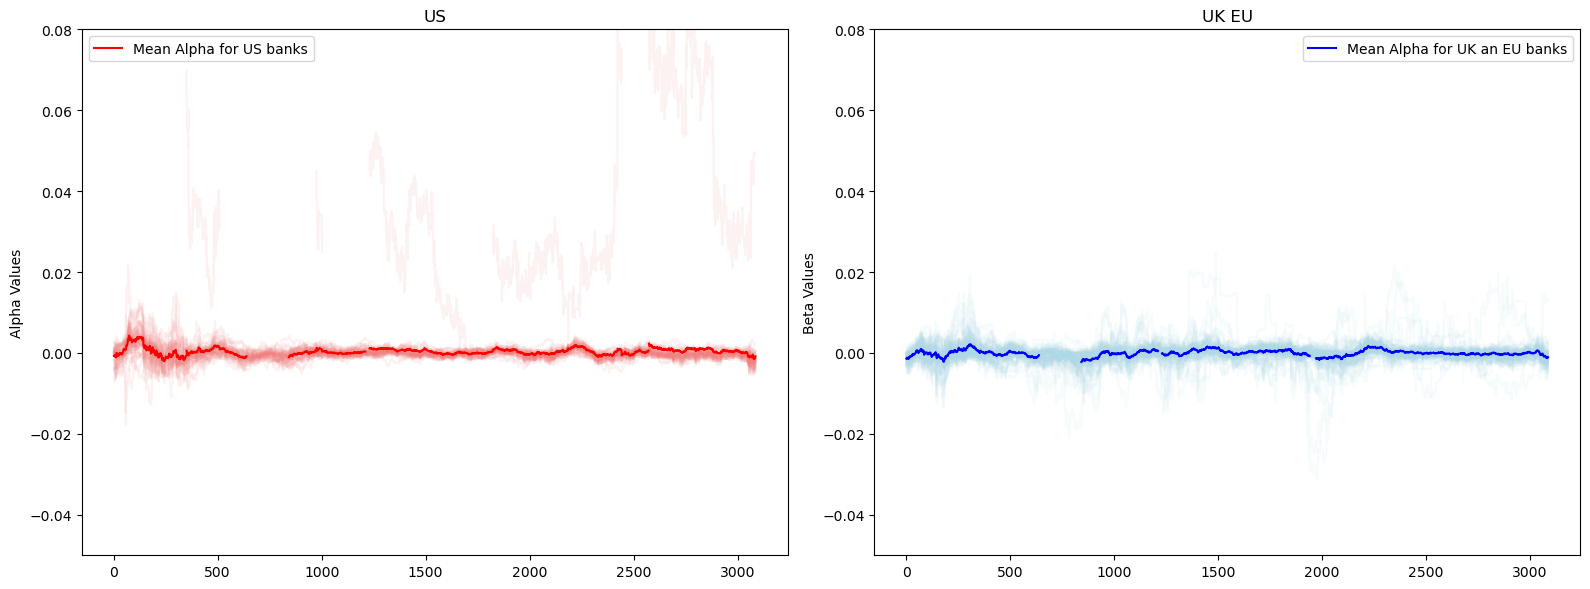

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

for col in alphas_df.columns:
    if col in us_banks:
        axs[0].plot(alphas_df.index, alphas_df[col], color="lightcoral", alpha=0.1)
axs[0].plot(alphas_df.index, alphas_df["us_banks"], color="red", label="Mean Alpha for US banks")

for col in alphas_df.columns:
    if col not in us_banks:
        axs[1].plot(alphas_df.index, alphas_df[col], color="lightblue", alpha=0.1)
axs[1].plot(alphas_df.index, alphas_df["eu_uk_banks"], color="blue", label="Mean Alpha for UK an EU banks")



# Set titles and labels
axs[1].set_title("UK EU")
axs[1].set_ylabel("Beta Values")
axs[0].set_title("US")
axs[0].set_ylabel("Alpha Values")
# Set y-axis limits
axs[0].set_ylim(-0.05, 0.08)
axs[1].set_ylim(-0.05, 0.08)


# Add legends
axs[0].legend()
axs[1].legend()
plt.tight_layout()  # Adjust spacing to prevent overlap
plt.show()

This plot is particularly interesting as it reveals distinct behaviors in the alpha estimates for US and European banks over time. For US banks, the alpha values tend to cluster closely around zero with relatively low variance, except at the start of the period. Notably, the early part of our sample corresponds to the 2008 financial crisis, a time of significant economic turmoil. It is not surprising to observe non-zero alpha values during this period, as the crisis represented a major exogenous shock that the CAPM could not account for. During such extreme market conditions, deviations from the expected returns predicted by CAPM are common, reflecting the impact of unforeseen factors like market panic, liquidity crunches, and abrupt changes in investor behavior.
In contrast, the alpha estimates for European banks display more inconsistency and higher variance throughout the period. This suggests that European banks, on average, experienced more frequent deviations from CAPM predictions, potentially due to several region-specific factors. The higher variance in alpha values could indicate the presence of idiosyncratic risks and structural challenges faced by the European banking sector during this time. For instance, the Eurozone debt crisis, which followed the 2008 financial meltdown, created prolonged economic instability in many European countries, leading to irregular performance among banks.

<div style="border: 4px solid #007bff; padding: 10px; background-color: #e9f5ff; border-radius: 5px;">
    <h1 style="color: #007bff;">Task 5 : compute CARs and merge Sigwatch + Datastream data</h1>
</div>

<div style="border: 4px solid #007bff; padding: 10px">
    <h3 style="color: #007bff;">Preparing the data</h1>
</div>

In [24]:
# We create a new dataset for task 5
task5_data = task4_data
first_day_posible_CAR = task5_data.iloc[300]["Date"]
task5_data.head(3)

,Date,Mkt-RF_US,Mkt-RF_EU,AAREAL BANK_PI_r,COMDIRECT BANK_PI_r,COMMERZBANK_PI_r,DT.PFANDBRIEFBANK_PI_r,PROCREDIT HOLDING_PI_r,UMWELTBANK_PI_r,ALLIANZ_PI_r,...,CLOSE BROTHERS GROUP_PI_r,VIRGIN MONEY UK_PI_r,HSBC HOLDINGS_PI_r,LLOYDS BANKING GROUP_PI_r,METRO BANK_PI_r,ROYAL BANK OF SCTL.GP._PI_r,STANDARD CHARTERED_PI_r,ADMIRAL GROUP_PI_r,ALLIANCE TRUST_PI_r,SAGA GROUP_PI_r
0,2008-01-01,0.04,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2008-01-02,-1.25,-0.11,0.008767,-0.003676,-0.018670,NaN,NaN,-0.003571,-0.017863,...,-0.000524,NaN,-0.008286,-0.006550,NaN,-0.013513,-0.005972,-0.00450,-0.002070,0.0
2,2008-01-03,-0.03,-0.13,-0.011587,0.000000,-0.012107,NaN,NaN,0.009409,-0.005681,...,0.000525,NaN,0.004113,0.005861,NaN,0.010280,-0.004362,0.00452,0.006946,0.0


In [25]:
# We need to match all the possible events in the sigwach dataset to a bank for which we have the data to calculate the CAR
df.reset_index(inplace = True, drop = True)
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")
# Make sure that we can actually calculate the CAR for all events
df = df[df["date"] > first_day_posible_CAR]
# Reduce dimension of the dataset
columns_needed_for_this_task = ["date", "company", "sentiment"]
df_sig = df[columns_needed_for_this_task].copy()

In [26]:
# Since we need to match bank names that are written slightly differently we need to clean the names
import re
def format_bank_names(l):
    l = [item.replace('_PI_r', '') for item in l]
    l = [item.lower() for item in l]
    l = [re.sub(r'[^a-zA-Z0-9\s]', '', item) for item in l]
    return l

In [27]:
# Here we get the names of the banks for which we have data, so that we can match each bank in the sigwatch dataset to one of these
l2 = list(task5_data.columns)[3:]
l2 = format_bank_names(l2)

In [28]:
# Now we define a function to match bank names, we tried many different approaches but this simple one 
# yielded the best results
def find_match(sig_company, l2):
    sig_company = sig_company.lower()
    sig_company = re.sub(r'[^a-zA-Z0-9\s]', '', sig_company)
    match = None
    for bank in l2:
        if sig_company in bank:
            match = bank
            break
    return match

In [29]:
# Now we apply the function to our reduced sigwatch dataset
df_sig["match"] = "Not Matched"
for idx, row in df.iterrows():
    df_sig.at[idx, "match"] = find_match(row["company"], l2)

df_sig.dropna(inplace = True)
df_sig.reset_index(inplace = True, drop = True)
df_sig.head(5)

,date,company,sentiment,match
0,2011-12-13,Deutsche Bank,0,deutsche bank
1,2011-12-13,HSBC,0,hsbc bank malta
2,2011-12-13,JP Morgan Chase,0,jp morgan chase co
3,2011-12-06,HSBC,-2,hsbc bank malta
4,2011-12-06,Deutsche Bank,-1,deutsche bank


In [30]:
# Now that we have performed the match in order to be able to match with banks from our task5_dataset
# we need to format it's columns to be compatable with our matches
unchanges_cols = list(task5_data.columns[:3])
changed_cols = list(task5_data.columns[3:])
formatted_changed_cols = format_bank_names(changed_cols)  
rename_dict = dict(zip(changed_cols, formatted_changed_cols))
task5_data = task5_data.rename(columns=rename_dict)

In [31]:
# We also need to format the us_banks list to make our life easier 
us_banks = format_bank_names(us_banks)

In [32]:
# This function directly calculates the CAR for a single bank and target day.

# NOTE: We have decided to keep the ±10 days window unchanged as we feel that making it larger
# would yield increased noise and reduced the precision of the abnormal return estimation.

def calculate_CAR(task5_data, bank, us_banks, target_day):
    current_bank = task5_data[["Date", f"{bank}"]].copy()
    mkt_data = get_mkt_data(bank_data, bank, us_banks)
    current_bank["MKT"] = mkt_data
    td_index = current_bank[current_bank["Date"] == target_day].index[0]
    
    past_data = current_bank.iloc[td_index - 300 : td_index - 50]
    today_plus_minus_10 = current_bank.iloc[td_index - 10 : td_index + 10].copy()

    X = sm.add_constant(past_data["MKT"])  
    y = past_data[bank] 
    
    # Fit the OLS regression
    model = sm.OLS(y, X).fit()
    alpha = model.params.iloc[0]
    beta = model.params.iloc[1]

    today_plus_minus_10[f"{bank}_hat"] = alpha + beta * today_plus_minus_10["MKT"]
    today_plus_minus_10["Abnormal Return"] = today_plus_minus_10[f"{bank}"] - today_plus_minus_10[f"{bank}_hat"]
    all_ARs = list(today_plus_minus_10["Abnormal Return"])
    return sum(all_ARs)

In [33]:
df_sig["CAR"] = "Not Calculated Yet"
for idx, row in df_sig.iterrows():
    df_sig.at[idx, "CAR"] = calculate_CAR(task5_data, row["match"], us_banks, row["date"])

In [46]:
from statistics import mean

positive_dict = {}
negative_dict = {}
for bank in list(df_sig["company"].unique()):
    cur_df = df_sig[df_sig["company"] == bank]
    positive_cars = []
    negative_cars = []
    for _, row in cur_df.iterrows():
        if row["sentiment"] >= 0:
            positive_cars.append(row["sentiment"])
        else:
            negative_cars.append(row["sentiment"])
        
    avg_pos_car = mean(positive_cars) if positive_cars else 0
    avg_neg_car = mean(negative_cars) if negative_cars else 0
    
    positive_dict[bank] = avg_pos_car
    negative_dict[bank] = avg_neg_car

/var/folders/j9/w6m91zxs22l58fngjqhl5xm80000gn/T/ipykernel_55583/3534450445.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_avg_cars, y=sorted_banks, palette="coolwarm")


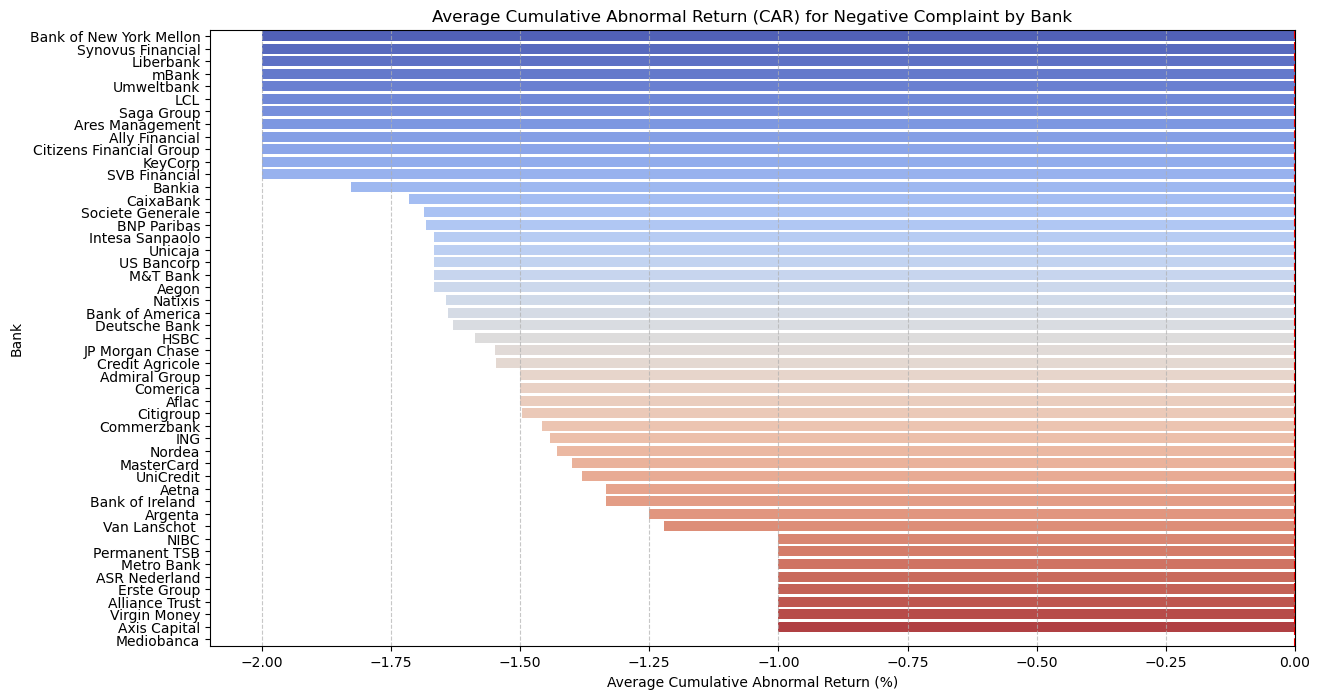

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

banks = list(negative_dict.keys())
average_cars = list(negative_dict.values())

sorted_indices = sorted(range(len(average_cars)), key=lambda k: average_cars[k])
sorted_banks = [banks[i] for i in sorted_indices]
sorted_avg_cars = [average_cars[i] for i in sorted_indices]

plt.figure(figsize=(14, 8))
sns.barplot(x=sorted_avg_cars, y=sorted_banks, palette="coolwarm")

plt.xlabel('Average Cumulative Abnormal Return (%)')
plt.ylabel('Bank')
plt.title('Average Cumulative Abnormal Return (CAR) for Negative Complaint by Bank')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.axvline(0, color='red', linestyle='--')

plt.show()

This graph illustrates the average Cumulative Abnormal Returns (CAR) surrounding the release of NGO complaints that contained negative sentiment in their text. As anticipated, the abnormal returns are predominantly negative, indicating that these complaints had a detrimental impact on the companies' stock performance. This negative reaction suggests that the market perceives such complaints as credible indicators of potential issues within the company, leading investors to adjust their expectations downward.

The decline in abnormal returns likely stems from several factors. Firstly, negative sentiment in NGO reports can signal underlying problems related to corporate social responsibility, environmental concerns, or unethical business practices

/var/folders/j9/w6m91zxs22l58fngjqhl5xm80000gn/T/ipykernel_55583/3024547491.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_avg_cars, y=sorted_banks, palette="coolwarm")


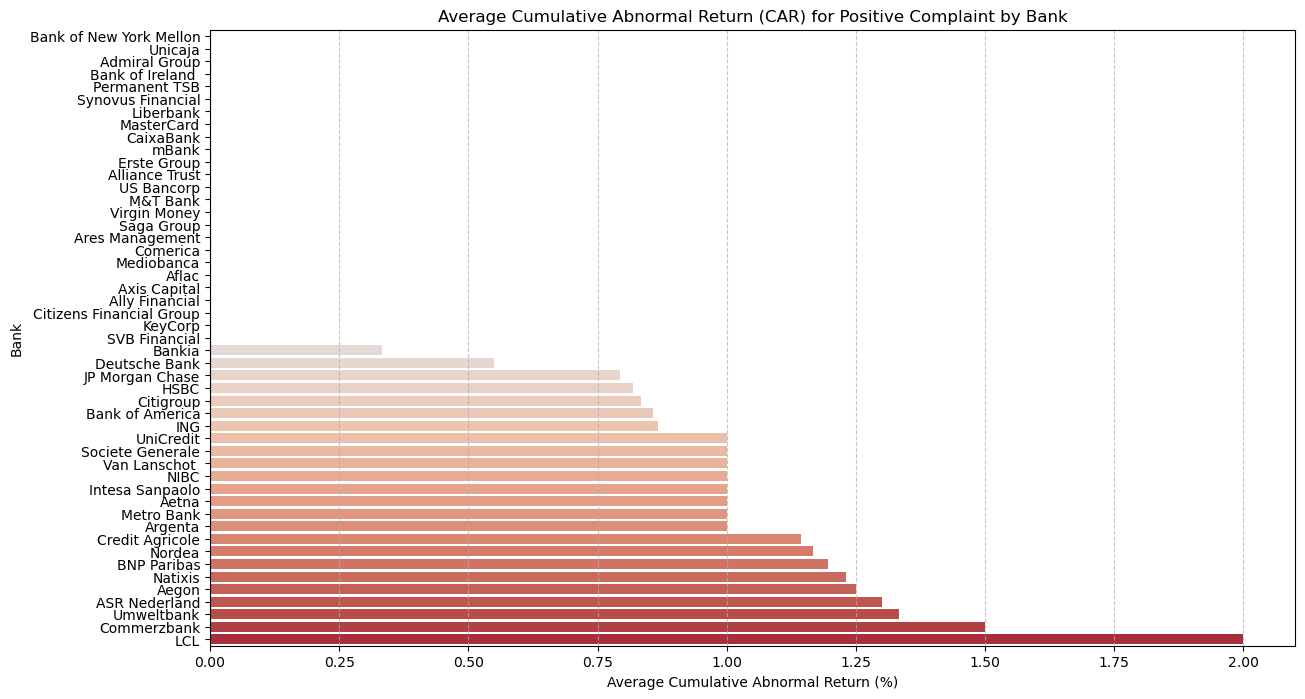

In [50]:
banks = list(positive_dict.keys())
average_cars = list(positive_dict.values())

sorted_indices = sorted(range(len(average_cars)), key=lambda k: average_cars[k])
sorted_banks = [banks[i] for i in sorted_indices]
sorted_avg_cars = [average_cars[i] for i in sorted_indices]

plt.figure(figsize=(14, 8))
sns.barplot(x=sorted_avg_cars, y=sorted_banks, palette="coolwarm")

plt.xlabel('Average Cumulative Abnormal Return (%)')
plt.ylabel('Bank')
plt.title('Average Cumulative Abnormal Return (CAR) for Positive Complaint by Bank')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.axvline(0, color='red', linestyle='--')

plt.show()

In contrast, this visualization presents the average Cumulative Abnormal Returns (CAR) surrounding the release of NGO complaints that conveyed a positive or neutral sentiment in their text. As expected, the abnormal returns are generally positive or close to zero, indicating that the market reaction to these types of complaints is either favorable or neutral.
On the higher end of the positive CAR spectrum, we can hypothesize that these instances are driven by significant positive news related to the banks involved. For example, announcements of new commitments to CSR initiatives.